In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('find_hacker').getOrCreate()

In [2]:
from pyspark.ml.clustering import KMeans
dataset = spark.read.csv("hack.csv",header=True,inferSchema=True)

In [3]:
dataset.head()

Row(Session_Connection_Time=8.0, Bytes Transferred=391.09, Kali_Trace_Used=1, Servers_Corrupted=2.96, Pages_Corrupted=7.0, Location='Slovenia', WPM_Typing_Speed=72.37)

In [4]:
dataset.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [20]:
x=dataset.toPandas()
kali=x[x['Kali_Trace_Used']==1]
nonkali=x[x['Kali_Trace_Used']==0]

In [23]:
kali_time=kali.iloc[:,0].values
nonkali_time=nonkali.iloc[:,0].values
kali_mb=kali.iloc[:,1].values
nonkali_mb=nonkali.iloc[:,1].values
kali_server=kali.iloc[:,3].values
nonkali_server=nonkali.iloc[:,3].values

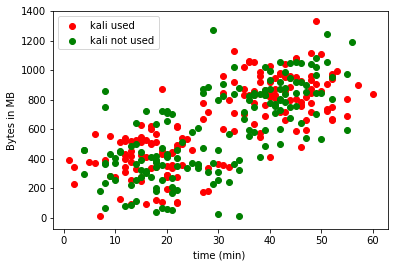

In [30]:
plt.scatter(kali_time,kali_mb,color='Red')
plt.scatter(nonkali_time,nonkali_mb,color='green')
plt.legend(['kali used','kali not used'])
plt.xlabel("time (min) ")
plt.ylabel("Bytes in MB")
plt.show()

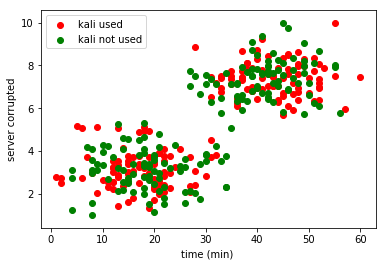

In [38]:
plt.scatter(kali_time,kali_server,color='Red')
plt.scatter(nonkali_time,nonkali_server,color='green')
plt.legend(['kali used','kali not used'])
plt.xlabel("time (min) ")
plt.ylabel("server corrupted")
plt.show()

In [10]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [11]:
feat_cols = ['Session_Connection_Time', 'Bytes Transferred', 'Kali_Trace_Used',
             'Servers_Corrupted', 'Pages_Corrupted','WPM_Typing_Speed']

In [12]:
vec_assembler = VectorAssembler(inputCols = feat_cols, outputCol='features')

In [13]:
final_data = vec_assembler.transform(dataset)

In [14]:
from pyspark.ml.feature import StandardScaler

In [15]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [16]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [17]:
# Normalize each feature to have unit standard deviation.
cluster_final_data = scalerModel.transform(final_data)

In [19]:
kmeans = KMeans(featuresCol='scaledFeatures',k=2)
model = kmeans.fit(cluster_final_data)
wssse = model.computeCost(cluster_final_data)
print("With K={}".format(2))
print("Within Set Sum of Squared Errors = " + str(wssse))

With K=2
Within Set Sum of Squared Errors = 601.7707512676716


In [31]:
model.transform(cluster_final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+



In [33]:
result=model.transform(cluster_final_data)

In [36]:
result.head()

Row(Session_Connection_Time=8.0, Bytes Transferred=391.09, Kali_Trace_Used=1, Servers_Corrupted=2.96, Pages_Corrupted=7.0, Location='Slovenia', WPM_Typing_Speed=72.37, features=DenseVector([8.0, 391.09, 1.0, 2.96, 7.0, 72.37]), scaledFeatures=DenseVector([0.5679, 1.3658, 1.9976, 1.2859, 2.2849, 5.3963]), prediction=0)